## Module 2 : Finding Neutral Atom Qubit Gates
### Exercise 2-1 : X-gate fidelity optimization with one Atom Qubits

**Exercise Goal:**
Perform a π pulse optimization to achieve X-gate operation:
- Integrate Gaussian pulse to find pulse area: $A = \int_{-\infty}^{\infty} \Omega_{01}(t)dt$
- Solve for pulse width $\sigma$ in terms of Rabi frequency $\Omega_0$ to achieve $A = \pi$
- Analytic formula: $A = \Omega_0 \sigma \sqrt{2\pi} = \pi \Rightarrow \sigma = \sqrt{\frac{\pi}{2\Omega_0^2}}$
- Optimize pulse width $\sigma$ for fixed $\Omega_0$ and compare with analytic value
- Measure fidelity by comparing final state with X-gate in computational subspace (2×2 extracted from 4×4 density matrix)

**Key Questions:**
1. What is the observed fidelity? Does it match expectations?
2. What error channels affect fidelity? (spontaneous emission, leakage, timing errors)
3. Is the optimal $\sigma$ consistent with the analytic formula?

Problems Unsolved : 
- fidelity above 1

In [1]:
%reload_ext autoreload
%autoreload 2

from common_imports import *
from scipy.optimize import minimize
from myPkg.optimization_utils import *

#### Optimize the pulse width with a fixed Rabi frequency $\Omega_0$

**Optimization Strategy:**
- Fix Rabi frequency $\Omega_0$ (MHz)
- Optimize pulse width $\sigma$ (μs) to maximize gate fidelity
- Constraint: Pulse area should be $\approx \pi$ for π pulse
- Compare optimal $\sigma$ with analytic value: $\sigma_{\text{theory}} = \sqrt{\frac{\pi}{2\Omega_0^2}}$

#### Parameters Setup

In [2]:
Omega_01_pulse_args = {"sigma": np.nan, "t0": np.nan, "amp_Omega_01": 1}

# Hamiltonian and Lindblad parameters
atom0_ham_params = dict(
  Omega_01 = (gaussian_pulse, Omega_01_pulse_args),  # Tuple: (function, args) 
  delta_1 = 0, 
  Omega_r = 0,
  Delta_r = 0
)

lindblad_params = dict(
  gamma_r = 1 / 540, 
  b_0r = 1/16, 
  b_1r = 1/16, 
  b_dr = 7/8
)

# Define target gate
target_gate = sigmax()
dim_qubits = 2**2

# Define initial states for gate fidelity computation
num_qubits = 1
dim_qubits = 2**num_qubits
dim_atom = 4 ** num_qubits
# initial state list for gate fidelity computation
psi0_list = make_initial_list_for_gate_fidelity(num_qubits, dim_atom)
qs0_list = make_initial_list_for_gate_fidelity(num_qubits, dim_qubits)
comp_indices = [0, 1] # indices of the computational basis states in the single-atom four-level system

#### Find Optimal Parameters for various values of $\Omega_0$ (MHz)

**Scan Strategy:**
- Test multiple Rabi frequencies: $\Omega_0 \in \{0.25, 0.5, 0.75, 1.0, 1.25, 1.5\}$ MHz
- For each $\Omega_0$, optimize pulse width $\sigma$
- Expected trend: $\sigma \propto 1/\Omega_0$ (from analytic formula)
- Compare optimized values with theory: $\sigma_{\text{theory}} = \sqrt{\frac{\pi}{2\Omega_0^2}}$

#### Path

In [3]:
from pathlib import Path
import time
from datetime import datetime

# Create save directory
task_name = 'X_gate_sigma_optimization'
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
folder_name = f"{timestamp}_{task_name}"
save_dir = Path('save_data') / 'XGate' / folder_name
save_dir.mkdir(parents=True, exist_ok=True)
print(f"💾 Save directory: {save_dir}")

💾 Save directory: save_data\XGate\20260108_171055_X_gate_sigma_optimization


#### Initial Parameters and Bounds

**Optimization Variables:**
- `sigma`: Pulse width (optimize)
- `t0`: Pulse center (fixed at 6 σ)
- `amp_Omega_01`: Rabi frequency (fixed for each scan, varies across scans)

**Bounds:**
- Allow $\sigma$ to vary broadly to find optimal value
- Fix $t_0$ and $\Omega_0$ for each individual optimization run

In [4]:
# Rydberg B list
amp_Omega_01_list = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5]

# Define initial parameters
initial_params = {
  'sigma': 1,
  't0': 6,
  'amp_Omega_01': 1,
}

# Define bounds
bounds = {
  'sigma': (0.5,10),
  't0': (6,6),
  'amp_Omega_01': (1,1),
}

# Optimization settings
param_names = ['sigma', 't0', 'amp_Omega_01']
x0 = np.array([initial_params[name] for name in param_names])
param_bounds = [bounds[name] for name in param_names]
options = {'maxiter': 300, 'disp': False, 'fatol': 1e-6, 'xatol': 1e-4}

#### Run Optimization for Different $\Omega_{01}$ Values

**Optimization Loop:**
For each fixed Rabi frequency $\Omega_{01} \in \{0.25, 0.5, 0.75, 1.0, 1.25, 1.5\}$ MHz:
1. Fix $\Omega_{01}$ (update bounds to make it constant)
2. Optimize pulse width $\sigma$ to maximize gate fidelity
3. Record optimal $\sigma$ and corresponding fidelity
4. Save optimization trajectory for convergence analysis

**Goal:**
Verify the theoretical relationship $\sigma \cdot \Omega_{01} = \sqrt{\frac{\pi}{2}} \approx 1.253$ for optimal π-pulse across different Rabi frequencies.

In [5]:
# Start computation
print(f"\n{'='*70}")
print(f"🚀 Starting Serial Optimization")
print(f"   Total Amplitude values: {len(amp_Omega_01_list)}")
print(f"{'='*70}\n")

total_start = time.time()
results = []

for idx, amp_Omega_01 in enumerate(amp_Omega_01_list):
    # update initial guess and bounds for current Omega_01
    x0[-1] = amp_Omega_01
    param_bounds[-1] = (amp_Omega_01, amp_Omega_01)
    
    print(rf"🚀 [{idx+1}/{len(amp_Omega_01_list)}] Starting $\Omega_{{01}}$ = {amp_Omega_01:.2f} MHz")
    start_time = time.time()
    
    # Create objective function for SINGLE QUBIT
    objective_func = create_SQ_pulse_optimizer(
        pulse_type='Gaussian',
        pulse_functions={'Omega_01': gaussian_pulse},  # Single pulse for single qubit
        atom_base_params=atom0_ham_params,  # Base params (no Omega01 yet)
        lindblad_params=lindblad_params,
        target_gate=target_gate,
        qs0_list=qs0_list,
        psi0_list=psi0_list,
        comp_indices=comp_indices,
        expect_list=None,
        fidelity_type='mixed',
        num_time_points=300
    )
    
    # Run optimization
    monitor = OptimizationMonitor(param_names, objective_func, verbose=False)
    result = minimize(objective_func, x0, method='Nelder-Mead',
                      bounds=param_bounds, options=options, callback=monitor)
    
    # Get best result
    best = monitor.get_best_result()
    best['amp_Omega_01'] = amp_Omega_01
    results.append(best)
    
    # Save individual result
    save_path = save_dir / f'monitor_Omega_01_{amp_Omega_01:.2f}MHz.pkl'
    monitor.save(save_path)
    
    elapsed = time.time() - start_time
    print(f"✅ [{idx+1}/{len(amp_Omega_01_list)}] Completed $\Omega_{{01}}$ = {amp_Omega_01:.2f} MHz, "
          f"F = {best['fidelity']:.6f}, Time = {elapsed:.1f}s\n")

total_time = time.time() - total_start

# Print summary
print(f"{'='*70}")
print(f"✅ Serial Optimization Complete!")
print(f"   Total time: {total_time/60:.1f} minutes")
print(f"   Average per $\Omega_{{01}}$: {total_time/len(results):.1f} seconds")
print(f"   Successful: {len(results)}/{len(amp_Omega_01_list)}")
print(f"{'='*70}\n")

<>:48: SyntaxWarning: invalid escape sequence '\O'
<>:57: SyntaxWarning: invalid escape sequence '\O'
<>:48: SyntaxWarning: invalid escape sequence '\O'
<>:57: SyntaxWarning: invalid escape sequence '\O'
C:\Windows\Temp\ipykernel_16500\2957672639.py:48: SyntaxWarning: invalid escape sequence '\O'
  print(f"✅ [{idx+1}/{len(amp_Omega_01_list)}] Completed $\Omega_{{01}}$ = {amp_Omega_01:.2f} MHz, "
C:\Windows\Temp\ipykernel_16500\2957672639.py:57: SyntaxWarning: invalid escape sequence '\O'
  print(f"   Average per $\Omega_{{01}}$: {total_time/len(results):.1f} seconds")
C:\Windows\Temp\ipykernel_16500\2957672639.py:35: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_func, x0, method='Nelder-Mead',
d:\anaconda3\envs\my_qiskit\Lib\site-packages\qutip\core\data\expm.py:139: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  return Dense(scipy.linalg.sqrtm(matrix.as_ndarray()))



🚀 Starting Serial Optimization
   Total Amplitude values: 6

🚀 [1/6] Starting $\Omega_{01}$ = 0.25 MHz



























































































































































✅ Saved optimization monitor to: save_data\XGate\20260108_171055_X_gate_sigma_optimization\monitor_Omega_01_0.25MHz.pkl
✅ [1/6] Completed $\Omega_{01}$ = 0.25 MHz, F = 1.000000, Time = 2.7s

🚀 [2/6] Starting $\Omega_{01}$ = 0.50 MHz



















































































































































✅ Saved optimization monitor to: save_data\XGate\20260108_171055_X_gate_sigma_optimization\monitor_Omega_01_0.50MHz.pkl
✅ [2/6] Completed $\Omega_{01}$ = 0.50 MHz, F = 1.000000, Time = 2.6s

🚀 [3/6] Starting $\Omega_{01}$ = 0.75 MHz



























































































































✅ Sav

In [6]:
# Create summary DataFrame
import pandas as pd

summary_data = [{
    'amp_Omega_01': r['amp_Omega_01'],
    'fidelity': r['fidelity'],
    **r['params']
} for r in results]

df = pd.DataFrame(summary_data)
df.to_csv(save_dir / 'summary.csv', index=False)

print(f"💾 Saved summary to: {save_dir / 'summary.csv'}\n")
print(df.to_string(index=False))

💾 Saved summary to: save_data\XGate\20260108_171055_X_gate_sigma_optimization\summary.csv

 amp_Omega_01  fidelity    sigma  t0
         0.25       1.0 5.013225 6.0
         0.50       1.0 2.506653 6.0
         0.75       1.0 1.671056 6.0
         1.00       1.0 1.253294 6.0
         1.25       1.0 1.002618 6.0
         1.50       1.0 0.835515 6.0


✅ Loaded optimization monitor from: save_data\XGate\20260108_171055_X_gate_sigma_optimization\monitor_Omega_01_1.25MHz.pkl
   Total iterations: 19
   Best fidelity: 1.00000004


(<Figure size 1200x800 with 4 Axes>,
 array([[<Axes: title={'center': 'Fidelity Convergence'}, xlabel='Iteration', ylabel='Fidelity'>,
         <Axes: title={'center': 'Infidelity Convergence'}, xlabel='Iteration', ylabel='Infidelity (log scale)'>],
        [<Axes: title={'center': 'Parameter Evolution'}, xlabel='Iteration', ylabel='Parameter Value'>,
         <Axes: title={'center': 'Normalized Parameter Evolution'}, xlabel='Iteration', ylabel='Normalized Change'>]],
       dtype=object))

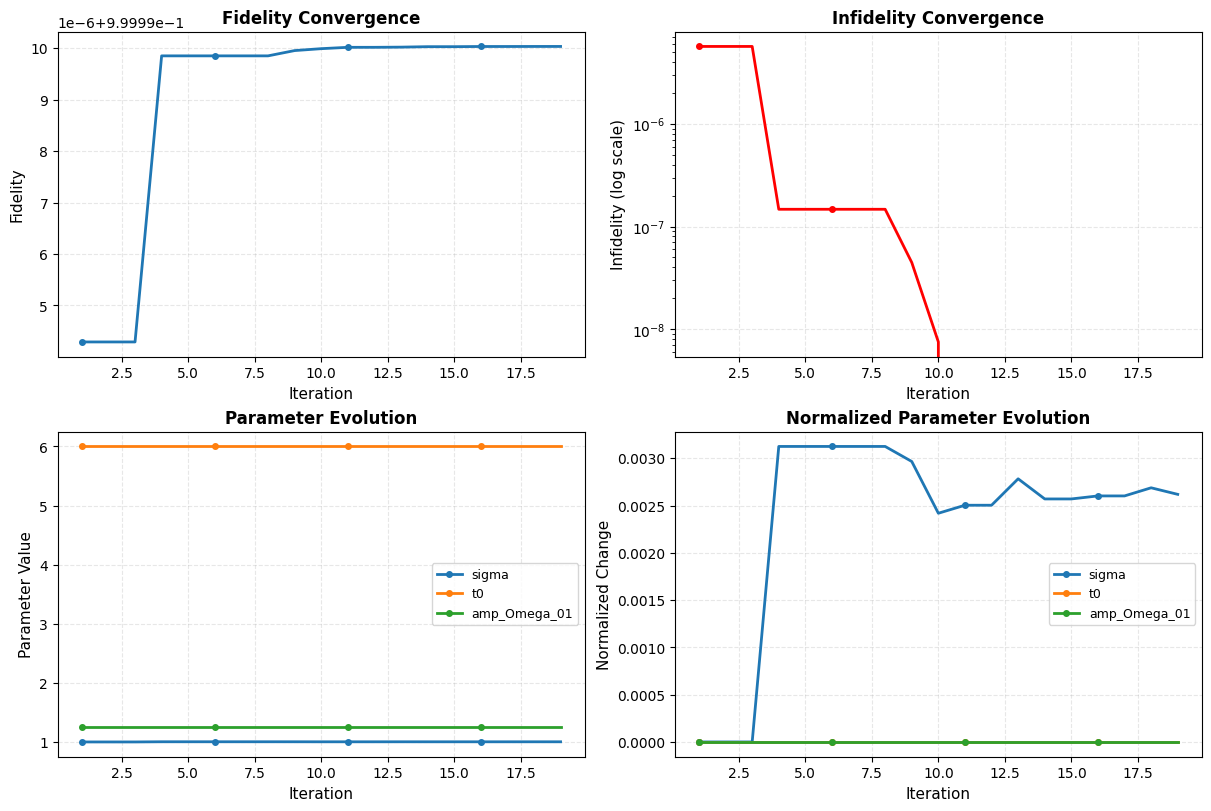

In [7]:
monitor = OptimizationMonitor.load(filepath=save_dir / 'monitor_Omega_01_1.25MHz.pkl', objective_func=objective_func)
monitor.plot_convergence()

### Plot Optimized $\sigma$ VS amplitude of $\Omega_{01}$

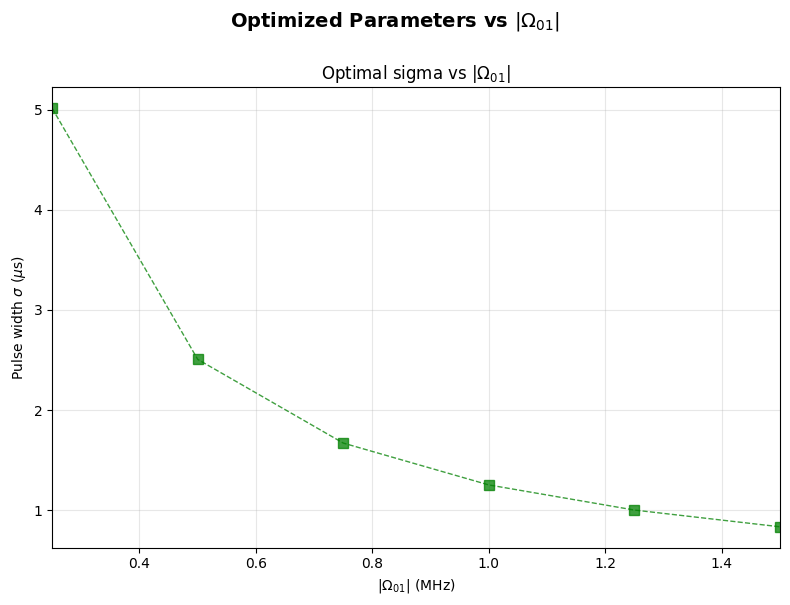

In [ ]:
# from myPkg.plotting_helpers import plot_parameter_vs_parameter

# fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# # Parameter information: (column_name, ylabel, need_conversion_to_MHz)
# param_info = [
#     ('sigma', r'Pulse width $\sigma$ ($\mu$s)', False, axes[0]),
#     ('fidelity', r'Fidelity $F$', False, axes[1]),
# ]

fig, ax = plt.subplots(figsize=(8, 6))

# Parameter information: (column_name, ylabel, need_conversion_to_MHz)
param_info = [
    ('sigma', r'Pulse width $\sigma$ ($\mu$s)', False, ax),
]

for param_name, ylabel, convert_to_MHz, ax in param_info:
    # Convert to appropriate units
    if convert_to_MHz:
        # Convert from rad/μs to MHz
        param_values = df[param_name].values / (2 * np.pi)
    else:
        param_values = df[param_name].values
    
    # Use plot_parameter_vs_parameter function
    plot_parameter_vs_parameter(
        ax=ax,
        x_param_list=df['amp_Omega_01'].values,
        y_param_list=[param_values],
        legend_list=[param_name],
        title=rf'Optimal {param_name} vs $|\Omega_{{01}}|$',
        xlabel=rf'$|\Omega_{{01}}|$ (MHz)',
        ylabel=ylabel,
        show_legend=False,
        grid_alpha=0.3
    )

plt.suptitle(r'Optimized Parameters vs $|\Omega_{{01}}|$', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### Conclusion
From the figure above, we can see that for different values of $\Omega_{01}$, the optimized $\sigma$ nearly satisfies the relation $\sigma\cdot\Omega_{01} = \sqrt{\frac{\pi}{2}}$